In [1]:
from google.colab import files
uploaded = files.upload()

Saving US_Original_dataset_final.zip to US_Original_dataset_final.zip


In [2]:
import zipfile
import io
data = zipfile.ZipFile(io.BytesIO(uploaded['US_Original_dataset_final.zip']), 'r')
data.extractall()

In [3]:
import os
from PIL import Image

In [4]:
def resizeAndSave(file_name):
  img_size=(229,229)  
  img = Image.open(file_name) 
  img = img.resize(img_size, Image.ANTIALIAS)  
  img.save(file_name)

In [5]:
benign_path = 'Benign/'
malignant_path = 'Malignant/'

In [6]:
#Resize images
def resizeDirectory(folder):
  folder_path = '/content/US_Original_dataset_final/'+folder+'/' 
  folder_b = folder_path + benign_path
  folder_m = folder_path + malignant_path

  mytrainBImages = os.listdir(folder_b)
  mytrainMImages = os.listdir(folder_m)

  for cl in mytrainBImages:
    file_nameb = folder_b + cl 
    resizeAndSave(file_nameb)    

  for cl in mytrainMImages:
    file_namem = folder_m + cl 
    resizeAndSave(file_namem)

In [7]:
resizeDirectory('test')
resizeDirectory('train')
resizeDirectory('validation')

In [8]:
train_path = '/content/US_Original_dataset_final/train'
test_path = '/content/US_Original_dataset_final/test'
val_path = '/content/US_Original_dataset_final/validation'



---



In [62]:
from matplotlib import pyplot
def summarize_diagnostics(history):
  # plot loss
  pyplot.figure(0)
  pyplot.title('Loss')
  pyplot.plot(history.history['loss'], color='blue', label='train')
  pyplot.plot(history.history['val_loss'], color='orange', label='test')
  pyplot.legend(['loss','val_loss']) 

  # plot accuracy
  pyplot.figure(1)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['binary_accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_binary_accuracy'], color='orange', label='test')
  pyplot.legend(['binary_accuracy','val_binary_accuracy'])

  # plot accuracy
  pyplot.figure(2)
  pyplot.title('Classification Accuracy')
  pyplot.plot(history.history['accuracy'], color='blue', label='train')
  pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
  pyplot.legend(['accuracy','val_accuracy'])

In [16]:
#functions to build confusion matrix
from tqdm import tqdm
import os
import cv2
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def load_data(dir_path):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    pyplot.figure(figsize = (6,6))
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=90)
    pyplot.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    pyplot.show()

x_test, y_test, labels = load_data('/content/US_Original_dataset_final/test/')
print(labels)

100%|██████████| 2/2 [00:00<00:00, 31.20it/s]

40 images loaded from /content/US_Original_dataset_final/test/ directory.
{0: 'Benign', 1: 'Malignant'}


In [17]:
classes = ['Benign', 'Malignant']

In [18]:
from sklearn.metrics import classification_report
def validateResults(model):   
  predictions = model.predict(x_test, batch_size=32)
  y_pred = np.argmax(predictions, axis=1) 
  y_true = np.argmax(y_test, axis=0)

  print("\n"+ classification_report(y_test, y_pred, target_names=classes))
  print(confusion_matrix(y_test, y_pred))
  confusion_mtx = confusion_matrix(y_test, y_pred)
  cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [9]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [68]:
def BuildModel():
  base_model = keras.applications.Xception(
    weights="imagenet", 
    input_shape=(229, 229, 3),
    include_top=False,
  )  
  # Freeze the base_model
  base_model.trainable = False
  # Create new model on top
  inputs = keras.Input(shape=(229, 229, 3))
  x = base_model(inputs, training=False)
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dropout(0.2)(x) 
  outputs = keras.layers.Dense(2, activation='sigmoid')(x)
  model = keras.Model(inputs, outputs)
  return model

In [69]:
model = BuildModel()
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 229, 229, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_9   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_9 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
___________________________________________

In [73]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 5, width_shift_range = 0.1, 
                               height_shift_range = 0.1, horizontal_flip = True)

train_it = datagen.flow_from_directory(train_path, batch_size=32, target_size=(229, 229))
validation_it = datagen.flow_from_directory(val_path, batch_size=32, target_size=(229, 229))

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [74]:
from keras import callbacks
from keras.callbacks import ReduceLROnPlateau
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4)
epochs = 100

In [78]:
def buildXceptionV1():
  modelv1 = BuildModel()

  modelv1.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(), 'accuracy'],
  )

  history = modelv1.fit(train_it, 
                    epochs=epochs, 
                    steps_per_epoch=len(train_it),
                    validation_data=validation_it,
                    validation_steps=len(validation_it),
                    verbose=1,
                    callbacks=[rlrop])
  
  return history, modelv1


In [82]:
historyv1, modelv1 = buildXceptionV1()

Epoch 1/100
4/4 [==============================] - 5s 744ms/step - loss: 1.3426 - binary_accuracy: 0.5714 - accuracy: 0.6122 - val_loss: 1.1158 - val_binary_accuracy: 0.4600 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 2s 399ms/step - loss: 0.8487 - binary_accuracy: 0.6020 - accuracy: 0.6531 - val_loss: 1.1368 - val_binary_accuracy: 0.5600 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 2s 420ms/step - loss: 1.1137 - binary_accuracy: 0.6582 - accuracy: 0.6939 - val_loss: 1.1352 - val_binary_accuracy: 0.6000 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 2s 397ms/step - loss: 1.0150 - binary_accuracy: 0.6224 - accuracy: 0.6735 - val_loss: 0.9637 - val_binary_accuracy: 0.4600 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 2s 812ms/step - loss: 1.1386 - binary_accuracy: 0.5612 - accuracy: 0.5306 - val_loss: 1.2512 - val_binary_acc

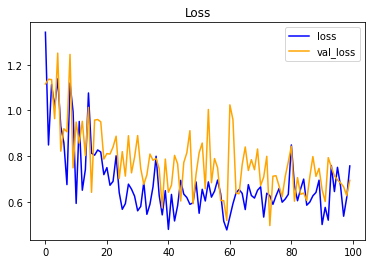

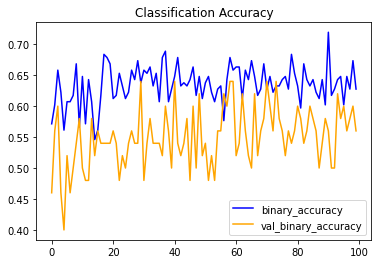

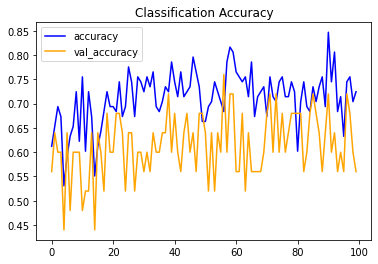

In [83]:
summarize_diagnostics(historyv1)


              precision    recall  f1-score   support

      Benign       0.72      0.81      0.76        26
   Malignant       0.55      0.43      0.48        14

    accuracy                           0.68        40
   macro avg       0.63      0.62      0.62        40
weighted avg       0.66      0.68      0.66        40

[[21  5]
 [ 8  6]]


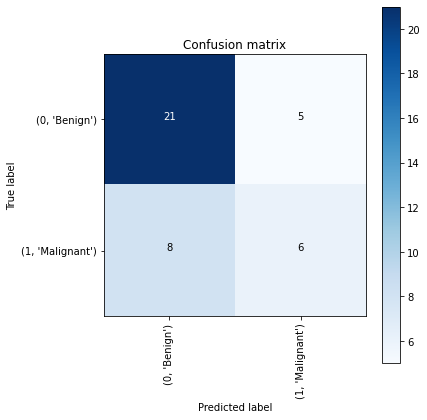

In [84]:
validateResults(modelv1)

In [85]:
def buildXceptionV2():
  modelv2 = BuildModel()

  modelv2.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=[keras.metrics.BinaryAccuracy(), 'accuracy'],
  )

  datagen2 = ImageDataGenerator()
  train_it_v2 = datagen.flow_from_directory(train_path, batch_size=32, target_size=(229, 229))
  validation_it_v2 = datagen.flow_from_directory(val_path, batch_size=32, target_size=(229, 229))

  history2 = modelv2.fit(train_it_v2, 
                    epochs=epochs, 
                    steps_per_epoch=len(train_it_v2),
                    validation_data=validation_it_v2,
                    validation_steps=len(validation_it_v2),
                    verbose=1,
                    callbacks=[rlrop])
  
  return history2, modelv2

In [86]:
historyv2, modelv2 = buildXceptionV2()

Found 98 images belonging to 2 classes.
Found 25 images belonging to 2 classes.
Epoch 1/100
4/4 [==============================] - 5s 759ms/step - loss: 1.2969 - binary_accuracy: 0.5612 - accuracy: 0.6531 - val_loss: 1.0174 - val_binary_accuracy: 0.5000 - val_accuracy: 0.6000 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 2s 407ms/step - loss: 1.2320 - binary_accuracy: 0.5051 - accuracy: 0.5816 - val_loss: 0.9679 - val_binary_accuracy: 0.5000 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 2s 544ms/step - loss: 1.1361 - binary_accuracy: 0.5102 - accuracy: 0.5204 - val_loss: 1.3266 - val_binary_accuracy: 0.5000 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 2s 419ms/step - loss: 1.1063 - binary_accuracy: 0.5153 - accuracy: 0.6224 - val_loss: 1.1136 - val_binary_accuracy: 0.5200 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 2s 400ms/step - loss: 1.0380 

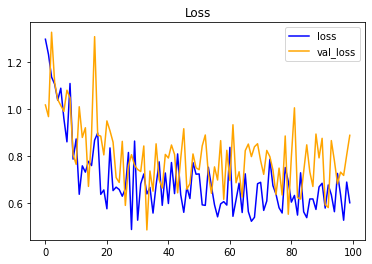

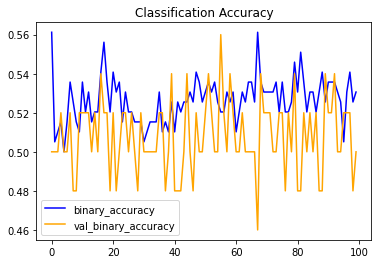

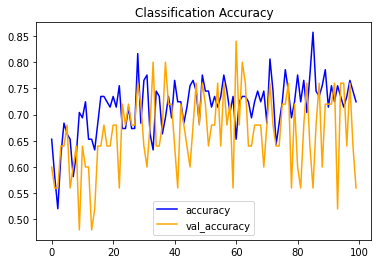

In [87]:
summarize_diagnostics(historyv2)


              precision    recall  f1-score   support

      Benign       0.69      0.85      0.76        26
   Malignant       0.50      0.29      0.36        14

    accuracy                           0.65        40
   macro avg       0.59      0.57      0.56        40
weighted avg       0.62      0.65      0.62        40

[[22  4]
 [10  4]]


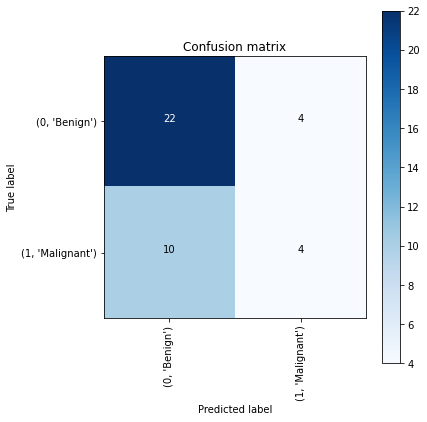

In [88]:
validateResults(modelv2)

In [89]:
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf

def buildXceptionV3():
  modelv3 = BuildModel()
  opt = tf.keras.optimizers.SGD(learning_rate=0.01)  
  modelv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[keras.metrics.BinaryAccuracy(),'accuracy'])

  history3 = modelv3.fit(train_it, 
                    epochs=epochs, 
                    steps_per_epoch=len(train_it),
                    validation_data=validation_it,
                    validation_steps=len(validation_it),
                    verbose=1,
                    callbacks=[rlrop])
  
  return history3, modelv3

In [90]:
historyv3, modelv3 = buildXceptionV3()

Epoch 1/100
4/4 [==============================] - 6s 767ms/step - loss: 18.4426 - binary_accuracy: 0.5459 - accuracy: 0.4694 - val_loss: 15.1533 - val_binary_accuracy: 0.6000 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 2s 418ms/step - loss: 24.1775 - binary_accuracy: 0.6786 - accuracy: 0.6735 - val_loss: 12.0817 - val_binary_accuracy: 0.6000 - val_accuracy: 0.6000 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 2s 403ms/step - loss: 10.1992 - binary_accuracy: 0.6429 - accuracy: 0.6327 - val_loss: 4.6436 - val_binary_accuracy: 0.6400 - val_accuracy: 0.6400 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 2s 420ms/step - loss: 10.5346 - binary_accuracy: 0.6837 - accuracy: 0.6939 - val_loss: 6.2425 - val_binary_accuracy: 0.4000 - val_accuracy: 0.2800 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 2s 422ms/step - loss: 17.7908 - binary_accuracy: 0.5714 - accuracy: 0.5510 - val_loss: 9.0376 - val_bin

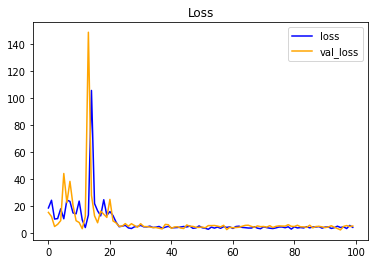

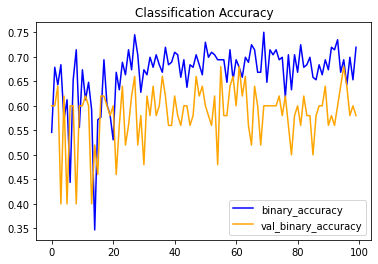

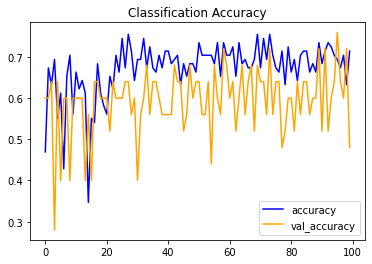

In [91]:
summarize_diagnostics(historyv3)


              precision    recall  f1-score   support

      Benign       0.66      0.81      0.72        26
   Malignant       0.38      0.21      0.27        14

    accuracy                           0.60        40
   macro avg       0.52      0.51      0.50        40
weighted avg       0.56      0.60      0.57        40

[[21  5]
 [11  3]]


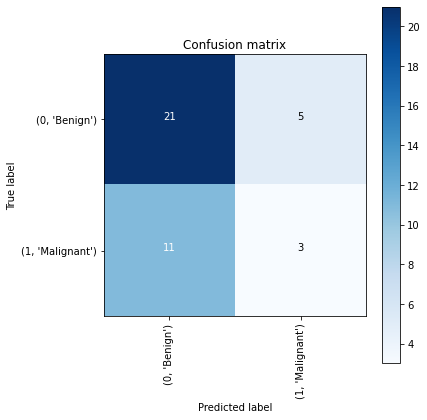

In [92]:
validateResults(modelv3)

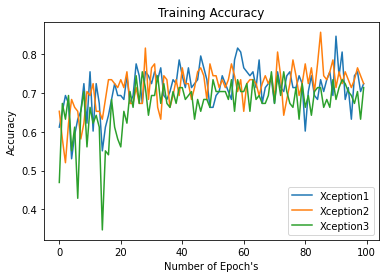

In [93]:
#gráfico compartido accuracy
pyplot.figure()
pyplot.plot(historyv1.history['accuracy'], label = 'Xception1')
pyplot.plot(historyv2.history['accuracy'], label = 'Xception2')
pyplot.plot(historyv3.history['accuracy'], label = 'Xception3')
pyplot.xlabel("Number of Epoch's")
pyplot.ylabel('Accuracy')
pyplot.title('Training Accuracy')
pyplot.legend(loc = "best")